In [67]:
from LPIPS_custom.custom_LPIPS import CustomFeatureMetric
import torch
import numpy as np

# It's more efficient to initialize the model once and reuse it.
# This global instance is a good pattern for that.
custom_lpips_model = CustomFeatureMetric(custom_vgg_path='./vgg16_finetuned_remeshed.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_lpips_model.to(device)

def custom_lpips(img1, img2):
    """
    Computes the LPIPS score using the fine-tuned VGG model.
    Handles numpy array inputs and converts them to the required tensor format.
    """
    # Ensure inputs are tensors and on the correct device
    # The LPIPS model expects input Tensors in shape [B, C, H, W] and range [-1, 1]
    # The model's forward pass handles normalization from [0, 1] to [-1, 1] by default.
    if not isinstance(img1, torch.Tensor):
        img1 = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0).float()
    
    if not isinstance(img2, torch.Tensor):
        img2 = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0).float()

    img1 = img1.to(device)
    img2 = img2.to(device)

    with torch.no_grad(): # Disable gradient calculation for efficiency
        result = custom_lpips_model(img1, img2)

    return round(float(result.item()), 9)

# Test with properly shaped arrays
img0 = np.zeros((64, 64, 3), dtype=np.float32)  # (H, W, C) format
img1 = np.ones((64, 64, 3), dtype=np.float32)   # (H, W, C) format

distance = custom_lpips(img0, img1)
print(f"LPIPS distance with custom VGG: {distance}")

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
LPIPS distance with custom VGG: 0.004107948


In [68]:
import pyiqa
models = pyiqa.list_models() 
print("Available models:")
# for model in models:
#     print(model)
gmsd_metric = pyiqa.create_metric('gmsd')
print(f'GMSD: {gmsd_metric.lower_better}')
lpips_metric = pyiqa.create_metric('lpips') 
print(f'LPIPS: {lpips_metric.lower_better}')


Available models:
GMSD: True
Loading pretrained model LPIPS from /Users/saikirannunemunthala/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth
LPIPS: True


In [69]:
from sewar.full_ref import mse,psnr,rmse_sw,uqi,ssim
# from torchmetrics.functional.image import relative_average_spectral_error
# from torchmetrics.functional.image import spectral_angle_mapper

The most commonly used Metri
 - MSE
 - PSNR
 - SSIM

The metrics that might be relavent
 - RMSE with sliding window
 - Universal Image quality metric
 - Gradient Magnitude Similarity metric 

Learned metric
 - LPIPS


In [70]:
import numpy as np
from scipy import ndimage 
from skimage.metrics import structural_similarity
from skimage.util import img_as_float
from skimage import filters
import warnings
warnings.filterwarnings('ignore')
import cv2
from PIL import Image

def mse_metric(img1, img2) -> float:
    """Mean Squared Error (MSE) - CORRECTED
        output: float - MSE in [0,1], lower is better
    """ 
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8) if img1.dtype != np.uint8 else img1
    img2 = (img2 * 255).astype(np.uint8) if img2.dtype != np.uint8 else img2
    
    return float(mse(img1, img2))

def mae_metric(img1, img2) -> float:
    """Mean Absolute Error (MAE) - Example new metric
        output: float - MAE in [0,1], lower is better
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    
    mae_value = np.mean(np.abs(img1 - img2))
    return float(np.clip(mae_value, 0, 1))

def rmse_sw_metric(img1, img2) -> float:
    """Root Mean Squared Error (RMSE) - CORRECTED
        output: float - RMSE in [0,1], lower is better
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8) if img1.dtype != np.uint8 else img1
    img2 = (img2 * 255).astype(np.uint8) if img2.dtype != np.uint8 else img2
    
    result = rmse_sw(img1, img2)
    # rmse_sw returns a tuple, we want just the rmse_value
    if isinstance(result, tuple):
        return float(result[0])
    return float(result)

def ssim_metric(img1, img2, ws=8) -> float:
    """Structural Similarity Index (2004) - CORRECTED
        output: float - SSIM in [0,1]
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8)
    img2 = (img2 * 255).astype(np.uint8)
    
    result = ssim(img1, img2)
    # ssim returns a tuple (ssim_value, cs_value), we want just the ssim_value
    if isinstance(result, tuple):
        return float(result[0])
    return float(result)
    # ws = min(ws, img1.shape[0]//2, img1.shape[1]//2)
    # if ws < 2:
    #     ws = 2
    # if ws % 2 == 0:
    #     ws += 1
    
    # # Use consistent data range
    # ssim_index = structural_similarity(img1, img2, win_size=ws, data_range=1.0)
    # return float(np.clip(ssim_index, 0, 1))

def psnr_metric(img1, img2) -> float:
    """Peak Signal-to-Noise Ratio (PSNR) - CORRECTED
        output: float - PSNR in dB, higher is better
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100.0  # Set a high but finite value instead of inf
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return float(psnr_value)

def uiqi_metric(img1, img2, ws=8) -> float:
    """Universal Image Quality Index (2002) - CORRECTED
        output: float - UIQI in [0,1]
    """ 
    
    # Proper grayscale conversion for BGR images
    if img1.ndim == 3:
        img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for sewar library
    img1 = (img1 * 255).astype(np.uint8) if img1.dtype != np.uint8 else img1
    img2 = (img2 * 255).astype(np.uint8) if img2.dtype != np.uint8 else img2
    
    result = uqi(img1, img2)
    # uqi might return a tuple, we want just the uqi value
    if isinstance(result, tuple):
        return float(result[0])
    return float(result)
    # ws = min(ws, img1.shape[0]//2, img1.shape[1]//2)
    # if ws < 2:
    #     ws = 2
    # # Ensure odd window size for consistency
    # if ws % 2 == 0:
    #     ws += 1
    
    # mu1 = np.array(ndimage.uniform_filter(img1, size=ws))[ws//2::ws, ws//2::ws]
    # mu2 = np.array(ndimage.uniform_filter(img2, size=ws))[ws//2::ws, ws//2::ws]
    # mu1_sq = np.array(ndimage.uniform_filter(img1*img1, size=ws))[ws//2::ws, ws//2::ws]
    # mu2_sq = np.array(ndimage.uniform_filter(img2*img2, size=ws))[ws//2::ws, ws//2::ws]
    # mu1_mu2 = np.array(ndimage.uniform_filter(img1*img2, size=ws))[ws//2::ws, ws//2::ws]
    
    # sigma1_sq = mu1_sq - mu1 * mu1
    # sigma2_sq = mu2_sq - mu2 * mu2
    # sigma12 = mu1_mu2 - mu1 * mu2
    
    # numerator = 4 * sigma12 * mu1 * mu2
    # denominator = (sigma1_sq + sigma2_sq) * (mu1 * mu1 + mu2 * mu2)
    
    # index = np.ones(denominator.shape)
    # valid_mask = denominator > 0
    # if np.any(valid_mask):
    #     index[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
    
    # score = float(np.mean(index))
    # return np.clip(score, 0, 1)

# def gmsd(img1, img2) -> float:
#     """Gradient Magnitude Similarity Deviation (2014) - CORRECTED
#         output: float - GMSD-based similarity in [0,1] (higher is better)
#     """ 
    
#     # Proper grayscale conversion for BGR images
#     if img1.ndim == 3:
#         img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
#     if img2.ndim == 3:
#         img2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    
#     gm1 = np.sqrt(filters.sobel_h(img1)**2 + filters.sobel_v(img1)**2)
#     gm2 = np.sqrt(filters.sobel_h(img2)**2 + filters.sobel_v(img2)**2)
    
#     c = 0.0026
#     gms = (2 * gm1 * gm2 + c) / (gm1**2 + gm2**2 + c)
    
#     gmsd_val = np.std(gms)
#     # Convert GMSD (dissimilarity) to similarity using exponential decay
#     # This is already a similarity measure (higher = more similar)
#     similarity = np.exp(-gmsd_val * 10)
#     return float(np.clip(similarity, 0, 1))


In [71]:
data_clipped_path = './AirfRANS_clipped'
data_remeshed_path = './AirfRANS_remeshed'

import os
import cv2
def load_images_from_folder(folder):
    p_arr = []
    ux_arr = []
    uy_arr = [] 
    for samples in os.listdir(folder):
        img_path_dir = os.path.join(folder, samples, 'meshes')
        if not os.path.isdir(img_path_dir):
            continue
        for image_path in os.listdir(img_path_dir):
            img_path = os.path.join(img_path_dir, image_path)
            if os.path.isfile(img_path) and img_path.endswith('.png'):
                filename = os.path.basename(img_path)
                if filename.split('_')[-1] == 'p.png':
                    p_arr.append(img_path)
                elif filename.split('_')[-1] == 'ux.png':
                    ux_arr.append(img_path)
                elif filename.split('_')[-1] == 'uy.png':
                    uy_arr.append(img_path)
                continue 
    return p_arr, ux_arr, uy_arr

data_clipped = load_images_from_folder(data_clipped_path)
data_remeshed = load_images_from_folder(data_remeshed_path)

In [72]:
# DYNAMIC METRIC CONFIGURATION
# Add any new metric here and it will automatically be included in the analysis
from tqdm import tqdm
def gmsd_pyiqa_metric(img1, img2) -> float:
    """GMSD metric using PyIQA - handles numpy arrays properly"""
    import torch
    import torchvision.transforms.functional as TF
    
    # Convert numpy arrays to PIL then to tensor
    if isinstance(img1, np.ndarray):
        # Ensure proper format for PIL conversion
        if img1.ndim == 3:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8))
        else:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8), mode='L').convert('RGB')
        img1_tensor = TF.to_tensor(img1_pil).unsqueeze(0)
    
    if isinstance(img2, np.ndarray):
        if img2.ndim == 3:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8))
        else:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8), mode='L').convert('RGB')
        img2_tensor = TF.to_tensor(img2_pil).unsqueeze(0)
    
    # Calculate GMSD
    result = gmsd_metric(img1_tensor, img2_tensor)
    return float(result.item())

def lpips_pyiqa_metric(img1, img2) -> float:
    """LPIPS metric using PyIQA - handles numpy arrays properly"""
    import torch
    import torchvision.transforms.functional as TF
    
    # Convert numpy arrays to PIL then to tensor
    if isinstance(img1, np.ndarray):
        if img1.ndim == 3:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8))
        else:
            img1_pil = Image.fromarray((img1 * 255).astype(np.uint8), mode='L').convert('RGB')
        img1_tensor = TF.to_tensor(img1_pil).unsqueeze(0)
    
    if isinstance(img2, np.ndarray):
        if img2.ndim == 3:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8))
        else:
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8), mode='L').convert('RGB')
        img2_tensor = TF.to_tensor(img2_pil).unsqueeze(0)
    
    # Calculate LPIPS
    result = lpips_metric(img1_tensor, img2_tensor)
    return float(result.item())

metric_funcs = {
    'mse': mse_metric,
    # 'mae': mae_metric,
    'rmse_sw': rmse_sw_metric,  # Example new metric
    'ssim': ssim_metric,
    'psnr': psnr_metric,
    'uiqi': uiqi_metric,
    'gmsd': gmsd_pyiqa_metric,  # Fixed GMSD function
    'lpips': lpips_pyiqa_metric,  # Fixed LPIPS function
    'c_lpips': custom_lpips,  # Custom LPIPS with fine-tuned VGG
    
}

# Metrics that need special normalization (raw value -> [0,1])
NORMALIZATION_RULES = {
    'psnr': lambda x: np.clip(x / 100, 0, 1),  # PSNR: dB -> [0,1]
    'mse': lambda x: 1 - np.clip(x / 65025, 0, 1),     # MSE: uint8 range (0-65025) -> [0,1], inverted
    'rmse_sw': lambda x: 1 - np.clip(x / 255, 0, 1),   # RMSE: uint8 range (0-255) -> [0,1], inverted
    # Add more normalization rules as needed
    # 'custom_metric': lambda x: your_normalization_function(x)
}

# DYNAMIC IQA METRICS COMPARISON FUNCTION
def compare_iqa_metrics(data_clipped, data_remeshed):
    """
    Compare IQA metrics dynamically - ALL METRICS IN [0,1] SCALE
    
    Automatically includes all metrics defined in metric_funcs dictionary.
    To add a new metric:
    1. Define the metric function
    2. Add it to metric_funcs dictionary
    3. Add normalization rule to NORMALIZATION_RULES if needed
    """
    results_p = []
    results_ux = []
    results_uy = []
    
    # Get metric names for dynamic processing
    metric_names = list(metric_funcs.keys())
    print(f"📊 Computing metrics: {metric_names}")
    
    for i in tqdm(range(len(data_clipped[0])), desc="Processing images"):
        # Load and crop images
        p_clipped = cv2.imread(data_clipped[0][i])[220:555, 256:955]
        ux_clipped = cv2.imread(data_clipped[1][i])[220:555, 256:955]
        uy_clipped = cv2.imread(data_clipped[2][i])[220:555, 256:955]
        
        p_remeshed = cv2.imread(data_remeshed[0][i])[220:555, 256:955]
        ux_remeshed = cv2.imread(data_remeshed[1][i])[220:555, 256:955]
        uy_remeshed = cv2.imread(data_remeshed[2][i])[220:555, 256:955]
        
        # Ensure images are in float format
        p_clipped = img_as_float(p_clipped)
        ux_clipped = img_as_float(ux_clipped)
        uy_clipped = img_as_float(uy_clipped)
        p_remeshed = img_as_float(p_remeshed)
        ux_remeshed = img_as_float(ux_remeshed)
        uy_remeshed = img_as_float(uy_remeshed)
        
        # Initialize result dictionaries for this sample
        sample_results_p = {}
        sample_results_ux = {}
        sample_results_uy = {}
        
        # DYNAMIC METRIC CALCULATION
        for metric_name, metric_func in metric_funcs.items():
            # print(f"Calculating metric: {metric_name}")

            # Calculate metrics for all three variables
            metric_p = metric_func(p_clipped, p_remeshed)
            metric_ux = metric_func(ux_clipped, ux_remeshed)
            metric_uy = metric_func(uy_clipped, uy_remeshed)
            
            # Apply normalization if specified
            if metric_name in NORMALIZATION_RULES:
                normalize_func = NORMALIZATION_RULES[metric_name]
                metric_p = normalize_func(metric_p)
                metric_ux = normalize_func(metric_ux)
                metric_uy = normalize_func(metric_uy)
            
            # Store results with consistent naming
            sample_results_p[f'{metric_name}_p'] = metric_p
            sample_results_ux[f'{metric_name}_ux'] = metric_ux
            sample_results_uy[f'{metric_name}_uy'] = metric_uy
        
        # Append to results lists
        results_p.append(sample_results_p)
        results_ux.append(sample_results_ux)
        results_uy.append(sample_results_uy)
    
    return results_p, results_ux, results_uy

# Run the dynamic function
print("Running dynamic IQA comparison...")
results_p, results_ux, results_uy = compare_iqa_metrics(data_clipped, data_remeshed)

# Create DataFrames dynamically
import pandas as pd
results_df_p = pd.DataFrame(results_p)
results_df_ux = pd.DataFrame(results_ux)
results_df_uy = pd.DataFrame(results_uy)

# DYNAMIC COLUMN RENAMING - automatically handle any number of metrics
def create_display_names(df, suffix):
    """Convert metric_p/metric_ux/metric_uy column names to clean display names"""
    rename_dict = {}
    for col in df.columns:
        # Extract metric name by removing the suffix
        if col.endswith(f'_{suffix}'):
            metric_name = col[:-len(f'_{suffix}')]
            display_name = metric_name.upper()
            rename_dict[col] = display_name
    return rename_dict

# Apply dynamic renaming
results_df_p = results_df_p.rename(columns=create_display_names(results_df_p, 'p'))
results_df_ux = results_df_ux.rename(columns=create_display_names(results_df_ux, 'ux'))
results_df_uy = results_df_uy.rename(columns=create_display_names(results_df_uy, 'uy'))

print("✅ Dynamic calculations completed!")
print(f"📊 Computed {len(results_df_p.columns)} metrics: {list(results_df_p.columns)}")



Running dynamic IQA comparison...
📊 Computing metrics: ['mse', 'rmse_sw', 'ssim', 'psnr', 'uiqi', 'gmsd', 'lpips', 'c_lpips']


Processing images: 100%|██████████| 11/11 [00:39<00:00,  3.61s/it]

✅ Dynamic calculations completed!
📊 Computed 8 metrics: ['MSE', 'RMSE_SW', 'SSIM', 'PSNR', 'UIQI', 'GMSD', 'LPIPS', 'C_LPIPS']


In [73]:
print("Pressure Metrics DataFrame:")
results_df_p

Pressure Metrics DataFrame:


,MSE,RMSE_SW,SSIM,PSNR,UIQI,GMSD,LPIPS,C_LPIPS
0,0.999144,0.972736,0.993726,0.306732,0.997893,0.010043,0.129483,2.968580e-04
1,0.999988,0.997136,0.998439,0.492610,0.999972,0.003663,0.003923,1.421000e-06
2,0.999995,0.998440,0.998129,0.531341,0.999988,0.003977,0.000910,4.340000e-07
3,0.999808,0.988157,0.995241,0.371749,0.999531,0.029013,0.013864,2.987000e-05
4,0.996948,0.945148,0.990018,0.251542,0.984448,0.012660,0.022055,1.009170e-04
5,0.999798,0.986044,0.998014,0.369451,0.999480,0.003770,0.006084,1.631600e-05
6,0.999783,0.985494,0.995852,0.366345,0.999053,0.005008,0.004451,8.710000e-06
7,0.999996,0.998799,0.998998,0.540152,0.999991,0.000832,0.002527,3.560000e-07
8,0.999990,0.997633,0.997602,0.499800,0.999972,0.003460,0.001163,7.230000e-07
9,0.999165,0.975306,0.990796,0.307851,0.997838,0.018183,0.317238,4.130010e-04


In [76]:
print("Velocity X Metrics DataFrame:")
results_df_ux

Velocity X Metrics DataFrame:


,MSE,RMSE_SW,SSIM,PSNR,UIQI,GMSD,LPIPS,C_LPIPS
0,0.999935,0.992072,0.998512,0.418769,0.999701,0.003137,0.001879,0.000003
1,0.999899,0.990262,0.997322,0.399583,0.999698,0.003478,0.002874,0.000006
2,0.999561,0.979239,0.995878,0.335727,0.998808,0.007240,0.010102,0.000031
3,0.999819,0.987942,0.991487,0.374248,0.999455,0.028146,0.006022,0.000012
4,0.998956,0.967932,0.992911,0.298115,0.997297,0.013221,0.031377,0.000091
5,0.999523,0.978344,0.996362,0.332183,0.998683,0.005332,0.010064,0.000030
6,0.999157,0.971351,0.993719,0.307430,0.997775,0.011747,0.021097,0.000071
7,0.999398,0.975618,0.996142,0.322029,0.998036,0.005729,0.007699,0.000028
8,0.999783,0.985678,0.996989,0.366268,0.999443,0.008149,0.012060,0.000027
9,0.991510,0.908128,0.975994,0.207111,0.966167,0.029042,0.044705,0.000286


In [77]:
print("Velocity Y Metrics DataFrame:")
results_df_uy

Velocity Y Metrics DataFrame:


,MSE,RMSE_SW,SSIM,PSNR,UIQI,GMSD,LPIPS,C_LPIPS
0,0.999713,0.984090,0.996470,0.354271,0.999074,0.012091,0.007561,1.293700e-05
1,0.999607,0.980406,0.995535,0.340522,0.998588,0.003394,0.008967,8.508000e-06
2,0.999566,0.979706,0.995684,0.336250,0.997848,0.005687,0.006473,6.943000e-06
3,0.999939,0.992464,0.998154,0.421192,0.999813,0.002627,0.001784,2.983000e-06
4,0.991413,0.909433,0.978279,0.206614,0.955599,0.018939,0.045287,1.144550e-04
5,0.990844,0.904693,0.974282,0.203828,0.967082,0.017108,0.080381,1.702670e-04
6,0.999946,0.993457,0.996269,0.426654,0.999745,0.003901,0.003825,1.357000e-06
7,0.999999,0.999615,0.999597,0.599956,0.999998,0.000221,0.001236,9.600000e-08
8,0.999986,0.997045,0.996280,0.484474,0.999948,0.004073,0.003192,6.240000e-07
9,0.998382,0.959875,0.993439,0.279092,0.995610,0.005523,0.025240,9.417500e-05


Comparison of highest and lowest values:
Pressure Metrics:
               max           min      diff  fold_change
MSE      0.999996  9.969481e-01  0.003048     1.003057
RMSE_SW  0.998799  9.451478e-01  0.053651     1.056765
SSIM     0.998998  9.846955e-01  0.014302     1.014525
PSNR     0.540152  2.515424e-01  0.288610     2.147360
UIQI     0.999991  9.844480e-01  0.015543     1.015789
GMSD     0.058229  8.315668e-04  0.057398    70.023349
LPIPS    0.317238  9.102946e-04  0.316327   348.500044
C_LPIPS  0.000413  3.560000e-07  0.000413  1160.115169
UX Metrics:
               max       min      diff  fold_change
MSE      0.999935  0.991510  0.008425     1.008497
RMSE_SW  0.992072  0.908128  0.083944     1.092437
SSIM     0.998512  0.975994  0.022518     1.023072
PSNR     0.418769  0.207111  0.211658     2.021957
UIQI     0.999701  0.966167  0.033533     1.034708
GMSD     0.029042  0.003137  0.025904     9.257489
LPIPS    0.044705  0.001879  0.042826    23.787248
C_LPIPS  0.000286  0.000

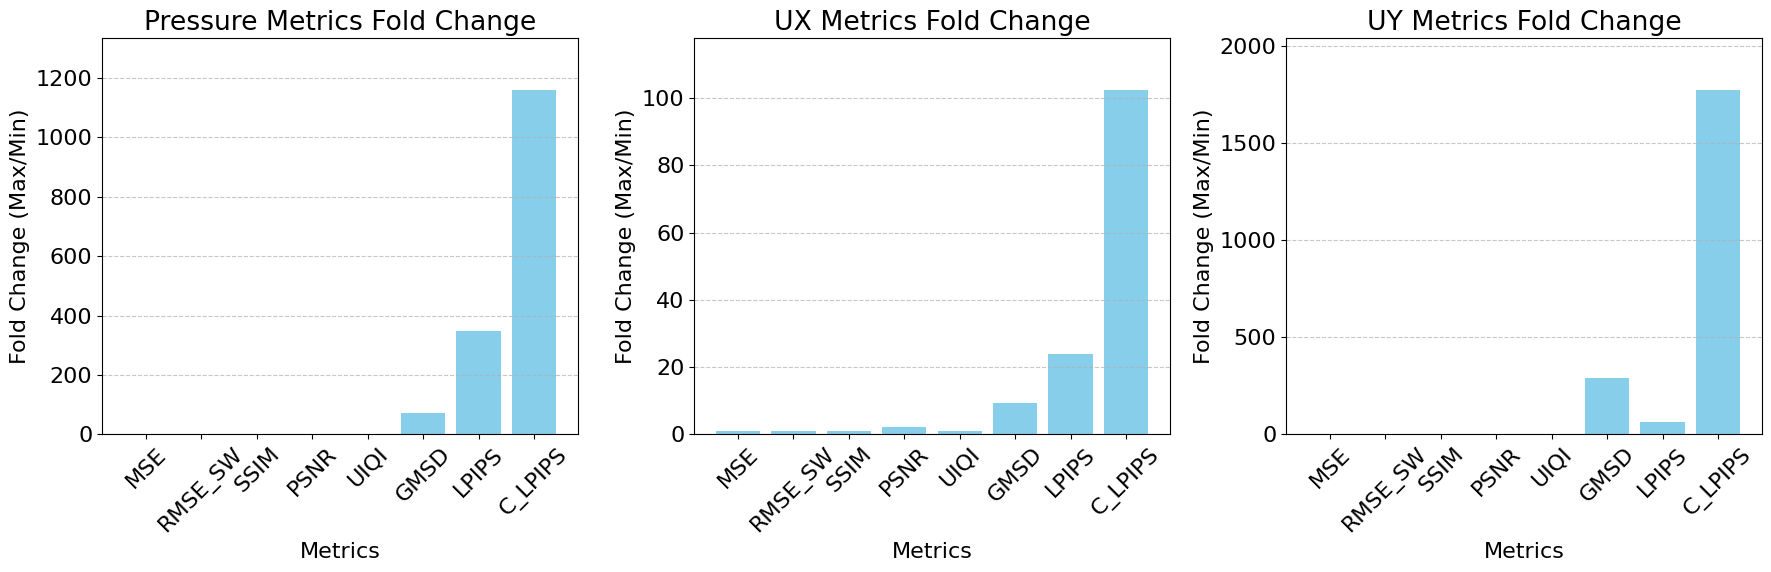

In [79]:
# compare highest and lowest values
def compare_highest_lowest(df):
    """Compare highest and lowest values in each column of the DataFrame"""
    comparison = {}
    for col in df.columns:
        max_value = df[col].max()
        min_value = df[col].min()
        comparison[col] = {
            'max': max_value,
            'min': min_value,
            'diff': max_value - min_value,
            "fold_change": (max_value / min_value) if min_value != 0 else np.inf
        }
    return pd.DataFrame(comparison).T

comparison_p = compare_highest_lowest(results_df_p)
comparison_ux = compare_highest_lowest(results_df_ux)
comparison_uy = compare_highest_lowest(results_df_uy)
print("Comparison of highest and lowest values:")
print("Pressure Metrics:\n", comparison_p)
print("UX Metrics:\n", comparison_ux)
print("UY Metrics:\n", comparison_uy)
import matplotlib.pyplot as plt 

# Display only the difference values in a bar plot
def plot_difference(comparison_df, title, ax, axis_y_off=False):
    """Plot the difference fold_change from the comparison DataFrame""" 
    ax.set_title(title)
    ax.bar(comparison_df.index, comparison_df['fold_change'], color='skyblue')
    ax.set_xlabel('Metrics') 
    ax.set_ylabel('Fold Change (Max/Min)') 
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.tick_params(axis='x', rotation=45)
    
    # Handle potential infinite values before setting y-limit
    finite_max = comparison_df.loc[np.isfinite(comparison_df['fold_change']), 'fold_change'].max()
    if pd.notna(finite_max) and finite_max > 0:
        ax.set_ylim(0, finite_max * 1.15)  # Add some space above the max value

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# plot font size increase for this plot
plt.rcParams.update({'font.size': 16})


plot_difference(comparison_p, 'Pressure Metrics Fold Change', axes[0])
plot_difference(comparison_ux, 'UX Metrics Fold Change', axes[1], True)
plot_difference(comparison_uy, 'UY Metrics Fold Change', axes[2], True)

plt.tight_layout()  # Apply tight layout to the whole figure
plt.show()



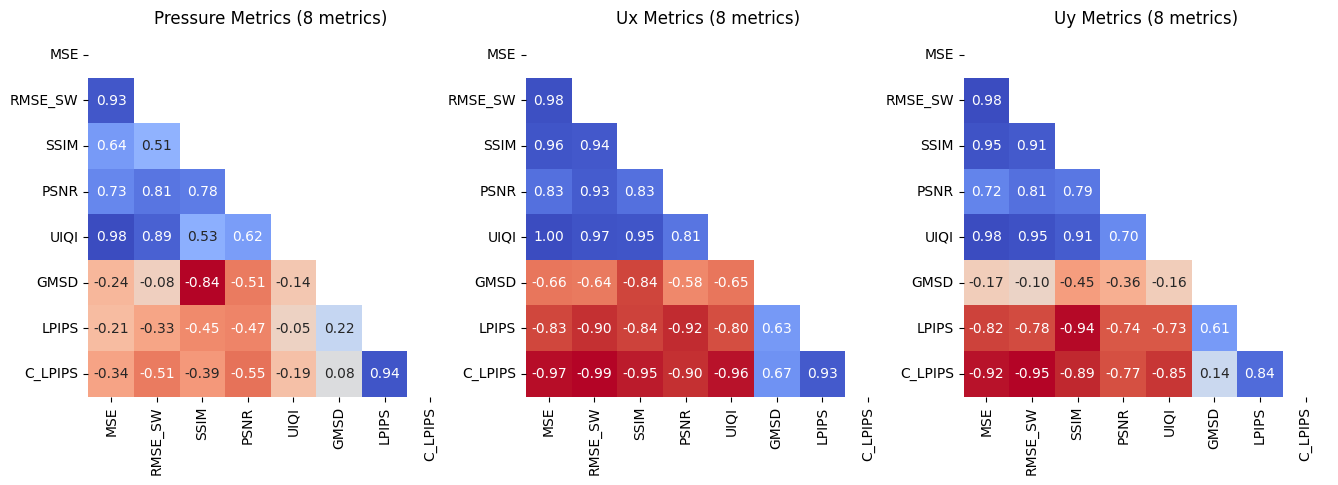


DYNAMIC IQA SYSTEM STATUS:
✅ Computed 8 metrics: ['MSE', 'RMSE_SW', 'SSIM', 'PSNR', 'UIQI', 'GMSD', 'LPIPS', 'C_LPIPS']
✅ All metrics normalized to [0,1] scale
✅ Dynamic correlation visualization
✅ Ready to add new metrics!


In [81]:
# DYNAMIC CORRELATION VISUALIZATION

import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

# Automatically adjust figure size based on number of metrics
n_metrics = len(results_df_p.columns)
fig_width = max(15, n_metrics * 2)  # Minimum 15, scale with metrics
fig, axes = plt.subplots(1, 3, figsize=(fig_width, 5))

# Pressure
sns.heatmap(results_df_p.corr(), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_p.corr(), dtype=bool)), ax=axes[0])
axes[0].set_title(f'Pressure Metrics ({n_metrics} metrics)') 
if len(axes[0].collections) > 0:
    axes[0].collections[0].colorbar.remove()

# Ux
sns.heatmap(results_df_ux.corr(), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_ux.corr(), dtype=bool)), ax=axes[1])
axes[1].set_title(f'Ux Metrics ({n_metrics} metrics)')
if len(axes[1].collections) > 0:
    axes[1].collections[0].colorbar.remove()

# Uy
sns.heatmap(results_df_uy.corr(), annot=True, cmap='coolwarm_r', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_uy.corr(), dtype=bool)), ax=axes[2])
axes[2].set_title(f'Uy Metrics ({n_metrics} metrics)')
if len(axes[2].collections) > 0:
    axes[2].collections[0].colorbar.remove()

plt.rcParams.update({'font.size': 10}) 
plt.show()

# Print summary of what's computed
print("\n" + "="*60)
print("DYNAMIC IQA SYSTEM STATUS:")
print("="*60)
print(f"✅ Computed {n_metrics} metrics: {list(results_df_p.columns)}")
print(f"✅ All metrics normalized to [0,1] scale")
print(f"✅ Dynamic correlation visualization")
print(f"✅ Ready to add new metrics!")
print("="*60)

In [82]:
# print correlation matrices
print("\nPressure Metrics Correlation Matrix:")
print(results_df_p.corr())
print("\nUx Metrics Correlation Matrix:")   
print(results_df_ux.corr())
print("\nUy Metrics Correlation Matrix:")
print(results_df_uy.corr()) 


Pressure Metrics Correlation Matrix:
              MSE   RMSE_SW      SSIM      PSNR      UIQI      GMSD     LPIPS  \
MSE      1.000000  0.932834  0.638898  0.730002  0.981130 -0.236619 -0.207888   
RMSE_SW  0.932834  1.000000  0.509227  0.808244  0.894047 -0.075869 -0.328873   
SSIM     0.638898  0.509227  1.000000  0.779215  0.529317 -0.841139 -0.453838   
PSNR     0.730002  0.808244  0.779215  1.000000  0.621512 -0.513220 -0.472486   
UIQI     0.981130  0.894047  0.529317  0.621512  1.000000 -0.143030 -0.051579   
GMSD    -0.236619 -0.075869 -0.841139 -0.513220 -0.143030  1.000000  0.221131   
LPIPS   -0.207888 -0.328873 -0.453838 -0.472486 -0.051579  0.221131  1.000000   
C_LPIPS -0.339481 -0.508788 -0.389127 -0.546977 -0.185149  0.079937  0.942815   

          C_LPIPS  
MSE     -0.339481  
RMSE_SW -0.508788  
SSIM    -0.389127  
PSNR    -0.546977  
UIQI    -0.185149  
GMSD     0.079937  
LPIPS    0.942815  
C_LPIPS  1.000000  

Ux Metrics Correlation Matrix:
              MSE   

Making sure the Custom LPIPS results are good

In [84]:

# Run the dynamic function
print("Running dynamic IQA comparison...")
results_p_same, results_ux_same, results_uy_same = compare_iqa_metrics(data_clipped, data_clipped)

Running dynamic IQA comparison...
📊 Computing metrics: ['mse', 'rmse_sw', 'ssim', 'psnr', 'uiqi', 'gmsd', 'lpips', 'c_lpips']


Processing images: 100%|██████████| 11/11 [00:39<00:00,  3.61s/it]


In [85]:

results_df_p_same = pd.DataFrame(results_p_same)
results_df_ux_same = pd.DataFrame(results_ux_same)
results_df_uy_same = pd.DataFrame(results_uy_same)

In [86]:
results_df_p_same

,mse_p,rmse_sw_p,ssim_p,psnr_p,uiqi_p,gmsd_p,lpips_p,c_lpips_p
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [87]:
results_df_ux_same

,mse_ux,rmse_sw_ux,ssim_ux,psnr_ux,uiqi_ux,gmsd_ux,lpips_ux,c_lpips_ux
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [88]:
results_df_uy_same

,mse_uy,rmse_sw_uy,ssim_uy,psnr_uy,uiqi_uy,gmsd_uy,lpips_uy,c_lpips_uy
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
